<a href="https://colab.research.google.com/github/tannguyen2512/cs-final-project/blob/master/diabetic_retinopathy_detection_feature_extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

## Download the dataset (only run once)

In [1]:
import os

In [2]:
if not os.path.exists('/content/resized-2015-2019-diabetic-retinopathy-detection.zip'):
    !kaggle datasets download -d c7934597/resized-2015-2019-diabetic-retinopathy-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [3]:
api_token = {"username":"talland","key":"60385cd2105d7ab6cfe161f266c447dc"}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
if not os.path.exists('/content/resized-2015-2019-diabetic-retinopathy-detection.zip'):
    !kaggle datasets download -d c7934597/resized-2015-2019-diabetic-retinopathy-detection

100% 17.3G/17.3G [04:51<00:00, 52.0MB/s]



In [ ]:
if not os.path.exists('/content/resized_traintest15_train19'):
    !unzip -n -q ./resized-2015-2019-diabetic-retinopathy-detection.zip -x resized_test19/* ;

In [ ]:
### OR By using directly from Google Cloud Service
# !pip install fsspec
# !pip install gcsfs

# GCS_PATH = 'gs://kds-a683652f772b5c920ffc24330c32fcf54b559630331c05ceb323a2a4' # <<<<<< FILL THE GOOGLE CLOUD SERVICE PATH EXTRACTED FROM KAGGLE NOTEBOOK HERE

# TEST
# import pandas as pd
# test = pd.read_csv(GCS_PATH+'/labels/traintestLabels15_trainLabels19.csv')
# test.head(3)

## Load library

In [7]:
!pip install --upgrade Pillow
!pip install tensorflow-addons

Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)


In [31]:
import pandas as pd
import numpy as np
import os
import pickle
import tqdm.notebook as tq

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow #Only in Colab

import tensorflow as tf
print("TensorFlow version: ",tf.__version__)
import tensorflow_addons as tfa
from tensorflow.data import Dataset

AUTOTUNE = tf.data.experimental.AUTOTUNE

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

TensorFlow version:  2.5.0


In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [10]:
# Check if GPU is ready to used (only for GPU runtime)
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1166119209044342976, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16183459840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18225519735846324990
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [11]:
###### Import Tensorflow and activate TPU (not use TPU)
# %tensorflow_version 2.x
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_addons as tfa

# import matplotlib.pyplot as plt
# import numpy as np

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#     print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#     raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# try:
#     tpu_strategy = tf.distribute.TPUStrategy(tpu)
# except:
#     tpu_strategy = tf.distribute.get_strategy()
# print('Number of replicas:', tpu_strategy.num_replicas_in_sync)

# AUTOTUNE = tf.data.experimental.AUTOTUNE

# print("Tensorflow version " + tf.__version__)

## Mount google drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Constants

In [13]:
index_class = {0:'No_DR', 1:'Mild', 2:'Moderate', 3:'Severe', 4:'Proliferative_DR'}

# GCS_PATH = 'gs://kds-a683652f772b5c920ffc24330c32fcf54b559630331c05ceb323a2a4' # <<<<<< FILL THE GOOGLE CLOUD SERVICE PATH EXTRACTED FROM KAGGLE NOTEBOOK HERE
RAW_DATA_FOLDER = './resized_traintest15_train19'
FINAL_PROJECT_FOLDER = '/content/drive/MyDrive/final_project'
BATCH_SIZE = 16
SEED = 25
IMG_SIZE = 224

tf.random.set_seed(SEED)
np.random.seed(SEED)

## Load metadata of labeled images (2015 train + 2015 test + 2019 train)

In [20]:
def remove_corrupted(df):
    corrupted_filepath = os.path.join(FINAL_PROJECT_FOLDER,'corrupted.pkl')
    with open(corrupted_filepath, 'rb') as f:
        corrupted = pickle.load(f)
    df.drop(index = df[df['filename'].isin(corrupted)].index, inplace = True)
    return df

In [21]:
def read_dataset_dataframe(csv_path = './labels/traintestLabels15_trainLabels19.csv', overwrite = False):
    '''
    Read the dataframe that contain image filename and labels
    '''
    save_file = os.path.join(FINAL_PROJECT_FOLDER,'traintestLabels15_trainLabels19.pkl')

    if (os.path.exists(save_file)) & (not overwrite) :
        with open(save_file, 'rb') as f:
            mod_df = pickle.load(f)
    else :
        df = pd.read_csv(csv_path)
        df.columns = ['filename', 'class']

        mod_df = df.copy()
        mod_df['class'] = mod_df['class'].astype(str)
        
        mod_df['fullpath'] = ''
        mod_df['height'] = 0
        mod_df['width'] = 0
        mod_df['year'] = 2019
        mod_df['s1_worse'] = 0
        mod_df['s2_worse'] = 0
        mod_df['s3_worse'] = 0
        mod_df['s4'] = 0

        def add_metadata(row):
            if '_' in row['filename'] : row['year'] = 2015
            row['filename'] = row['filename']+'.jpg'
            row['fullpath'] = os.path.join(RAW_DATA_FOLDER,row['filename'])
            tmp = Image.open(row['fullpath'])
            row['height'] = tmp.size[0]
            row['width'] = tmp.size[1]
            if row['class'] in ['1','2','3','4'] :  row['s1_worse'] = 1 
            if row['class'] in ['2','3','4'] :      row['s2_worse'] = 1 
            if row['class'] in ['3','4'] :          row['s3_worse'] = 1 
            if row['class'] == '4' :                row['s4'] = 1 
            return row
        mod_df = mod_df.apply(add_metadata, axis = 1)
        
        mod_df = remove_corrupted(mod_df)
            
        with open(save_file, 'wb') as f :
            pickle.dump(mod_df,f)

    return mod_df

In [22]:
df = read_dataset_dataframe(overwrite = False)
df.sample(5)

filename class  ... s3_worse  s4
60755  21309_right.jpg     0  ...        0   0
1821    2270_right.jpg     0  ...        0   0
56476   17740_left.jpg     0  ...        0   0
70112   28955_left.jpg     0  ...        0   0
60042   20715_left.jpg     2  ...        0   0

[5 rows x 10 columns]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92351 entries, 0 to 92363
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  92351 non-null  object
 1   class     92351 non-null  object
 2   fullpath  92351 non-null  object
 3   height    92351 non-null  int64 
 4   width     92351 non-null  int64 
 5   year      92351 non-null  int64 
 6   s1_worse  92351 non-null  int64 
 7   s2_worse  92351 non-null  int64 
 8   s3_worse  92351 non-null  int64 
 9   s4        92351 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 7.8+ MB


## Class weight

In [27]:
sample_count = list(np.bincount(df['class']))
sample_count = np.array(sample_count)
sample_count

array([67141,  6573, 14148,  2280,  2209])

In [28]:
weight = 1 / np.array(sample_count) * sample_count.sum() / sample_count.shape[0]
for i in range(len(weight)) :
    print('Weight for class {}: {:.3f}'.format(i, weight[i]))

Weight for class 0: 0.275
Weight for class 1: 2.810
Weight for class 2: 1.305
Weight for class 3: 8.101
Weight for class 4: 8.361


In [29]:
class_weight = {i: weight[i] for i in range(len(weight)) }
class_weight

{0: 0.2750956941362208,
 1: 2.810010649627263,
 2: 1.3054990104608426,
 3: 8.100964912280702,
 4: 8.361339972838389}

## Split data into train validation set

In [ ]:
def split_train_val_test_from_df(origin, subset_ratio = 1, val_ratio = 0.1, test_ratio = 0.1, seed = None, balance_train = False, balance_val = False, balance_dataset = False):
    '''
    Split the DataFrame containing image filenames and their class
    into smaller DataFrame for training and validation.
    The function does stratified sampling.
    Inputs are: dataframe df, ratio for validation data, and a seed for random state
    '''
    def resample_minor(minor_df, major_df):
        ids = np.arange(minor_df.shape[0])
        choices = np.random.choice(ids, major_df.shape[0])
        res = minor_df.iloc[choices]
        return res

    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()

    if balance_dataset: 
        c0_sample = df[df['class']=='0']
        c1_sample = df[df['class']=='1']
        res_c1 = resample_minor(c1_sample, c0_sample)
        c2_sample = df[df['class']=='2']
        res_c2 = resample_minor(c2_sample, c0_sample)
        c3_sample = df[df['class']=='3']
        res_c3 = resample_minor(c3_sample, c0_sample)
        c4_sample = df[df['class']=='4']
        res_c4 = resample_minor(c4_sample, c0_sample)

        oversampling_df = pd.concat([c0_sample, res_c1, res_c2, res_c3, res_c4], axis = 0)
        oversampling_df = oversampling_df.sample(frac = 1, random_state = seed)
        origin = oversampling_df

    if balance_train: 
        class_n_train = int(origin.shape[0] * subset_ratio * (1 - val_ratio - test_ratio))
        class_n_train = class_n_train // origin['class'].nunique()
        class_n_train = min(class_n_train, origin['class'].value_counts().min())

    if balance_val: 
        class_n_val = int(origin.shape[0] * subset_ratio * val_ratio)
        class_n_val = class_n_val // origin['class'].nunique()
        class_n_val = min(class_n_val, origin['class'].value_counts().min() - class_n_train)
        
    for c in origin['class'].unique():
        subset = origin[origin['class'] == c]
        subset = subset.sample(frac = 1, random_state = seed)
        
        if balance_train :
            n_train = class_n_train 
        else:  
            n_train = int((1 - val_ratio - test_ratio) * subset_ratio * subset.shape[0])
        if balance_train :
            n_val = class_n_val 
        else:  
            n_val = int(val_ratio * subset_ratio * subset.shape[0])
        n_test = int(test_ratio * subset_ratio * subset.shape[0])
        
        train_split_ix = n_train
        val_split_ix = train_split_ix + n_val
        test_split_ix = val_split_ix + n_test
        
        train_subset = subset.iloc[:train_split_ix,:]
        val_subset = subset.iloc[train_split_ix:val_split_ix,:]
        test_subset = subset.iloc[val_split_ix:test_split_ix,:]
        
        train_df = pd.concat([train_df, train_subset])
        val_df = pd.concat([val_df, val_subset])
        test_df = pd.concat([test_df, test_subset])
        
    a = origin['class'].value_counts().sort_index()
    b = train_df['class'].value_counts().sort_index()
    c = val_df['class'].value_counts().sort_index()
    d = test_df['class'].value_counts().sort_index()
    e = pd.concat([a,b,c,d], axis = 1)
    
    e.columns = ['Full','Train','Validation','Test']
    print("Split dataframes class counts:")
    # print(e)
    tmp = np.sum(e, axis=0)
    tmp = pd.DataFrame(tmp).transpose()
    tmp.index = ['Total']
    # print(tmp)
    print(pd.concat([e, tmp], axis = 0))

    train_df = train_df.sample(frac = 1, random_state = seed)
    val_df = val_df.sample(frac = 1, random_state = seed)
    test_df = test_df.sample(frac = 1, random_state = seed)
    
    return train_df, val_df, test_df

In [ ]:
#@title
# subset_ratio = 0.08
# val_ratio = 0.2
# test_ratio = 0.0

# train_df, val_df, test_df = split_train_val_test_from_df(
#     df, subset_ratio = subset_ratio, 
#     val_ratio = val_ratio, 
#     test_ratio = test_ratio,
#     seed = SEED,
#     balance_train = False, 
#     balance_val = False,
#     balance_dataset = True)

In [32]:
subset_ratio = 0.08
val_ratio = 5000
test_ratio = 20000

train_df, val_df = train_test_split(df, test_size=val_ratio, train_size=test_ratio, random_state=SEED, stratify=df['class'])

print('Dataset distribution')
print(df['class'].value_counts().sort_index())
print(df.shape)
print('='*20)
print('Train set distribution')
print(train_df['class'].value_counts().sort_index())
print(train_df.shape)
print('='*20)
print('Validation set distribution')
print(val_df['class'].value_counts().sort_index())
print(val_df.shape)

Dataset distribution
0    67141
1     6573
2    14148
3     2280
4     2209
Name: class, dtype: int64
(92351, 10)
Train set distribution
0    14540
1     1424
2     3064
3      494
4      478
Name: class, dtype: int64
(20000, 10)
Validation set distribution
0    3635
1     356
2     766
3     123
4     120
Name: class, dtype: int64
(5000, 10)


# Preprocessing

## Dummy function

(814, 1023, 3)
(224, 224, 3)


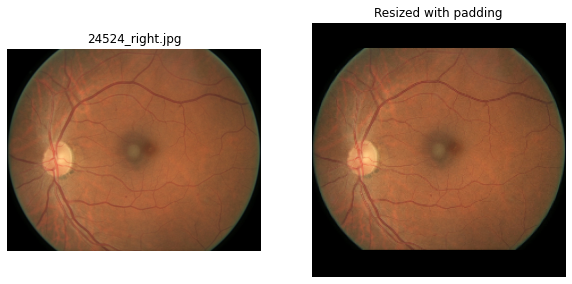

In [33]:
#@title resize with padding
def dummy_func():
    dummy_file = df.sample(1)
    dummy = tf.io.read_file(dummy_file.fullpath.values[0])
    dummy = tf.io.decode_jpeg(dummy)
    print(dummy.shape)
    resize_pad = tf.image.resize_with_pad(dummy, IMG_SIZE, IMG_SIZE)
    print(resize_pad.shape)

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(dummy.numpy().astype("uint8"))
    plt.title(dummy_file.filename.values[0])
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(resize_pad.numpy().astype("uint8"))
    plt.title("Resized with padding")
    plt.axis("off")

dummy_func()

(1021, 1023, 3)


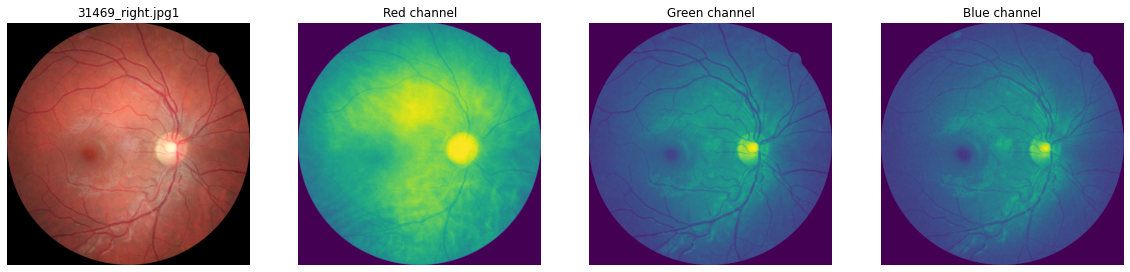

In [34]:
#@title separate channel
def dummy_func():
    dummy_file = df.sample(1)
    dummy = tf.io.read_file(dummy_file.fullpath.values[0])
    dummy = tf.io.decode_jpeg(dummy)
    print(dummy.shape)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plt.imshow(dummy.numpy().astype("uint8"))
    plt.title(dummy_file['filename'].values[0] + dummy_file['class'].values[0])
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(dummy[:,:,0].numpy().astype("uint8"))
    plt.title("Red channel")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(dummy[:,:,1].numpy().astype("uint8"))
    plt.title('Green channel')
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(dummy[:,:,2].numpy().astype("uint8"))
    plt.title('Blue channel')
    plt.axis("off")

dummy_func()

(1024, 1022, 3)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


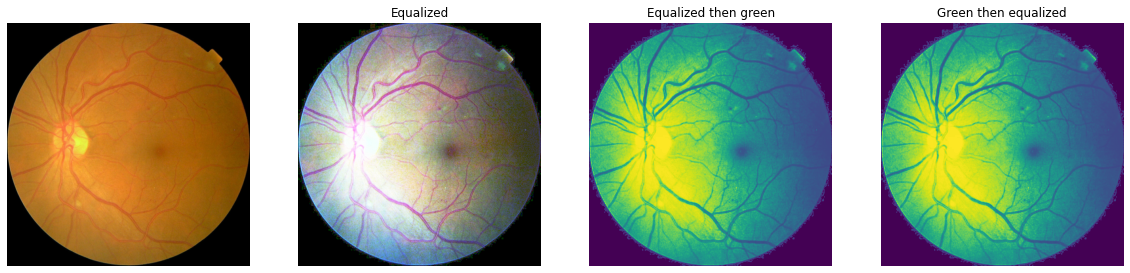

In [35]:
#@title histogram equalization
def dummy_func(filepath = None):
    if filepath == None :
        dummy_file = df.sample(1)
        dummy = tf.io.read_file(dummy_file.fullpath.values[0])
    else :
        dummy = tf.io.read_file(filepath)
    dummy = tf.io.decode_jpeg(dummy)
    print(dummy.shape)
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(dummy.numpy().astype("uint8"))
    if filepath == None :
        plt.title(dummy_file['filename'].values[0] + " class " + dummy_file['class'].values[0])
    plt.axis("off")

    pdummy = tfa.image.equalize(dummy, bins = 256)
    plt.subplot(1,4,2)
    plt.imshow(pdummy.numpy().astype("uint8"))
    plt.title("Equalized")
    plt.axis("off")
    
    pdummy = tfa.image.equalize(dummy, bins = 256)
    plt.subplot(1,4,3)
    plt.imshow(pdummy[:,:,1].numpy().astype("uint8"))
    plt.title("Equalized then green")
    plt.axis("off")

    pdummy = tfa.image.equalize(dummy[:,:,1], bins = 256)
    plt.subplot(1,4,4)
    plt.imshow(pdummy.numpy().astype("uint8"))
    plt.title("Green then equalized")
    plt.axis("off")

dummy_func('/content/resized_traintest15_train19/32711_left.jpg')

## Preprocess in openCV

CPU times: user 1.1 s, sys: 38.7 ms, total: 1.14 s
Wall time: 1.11 s


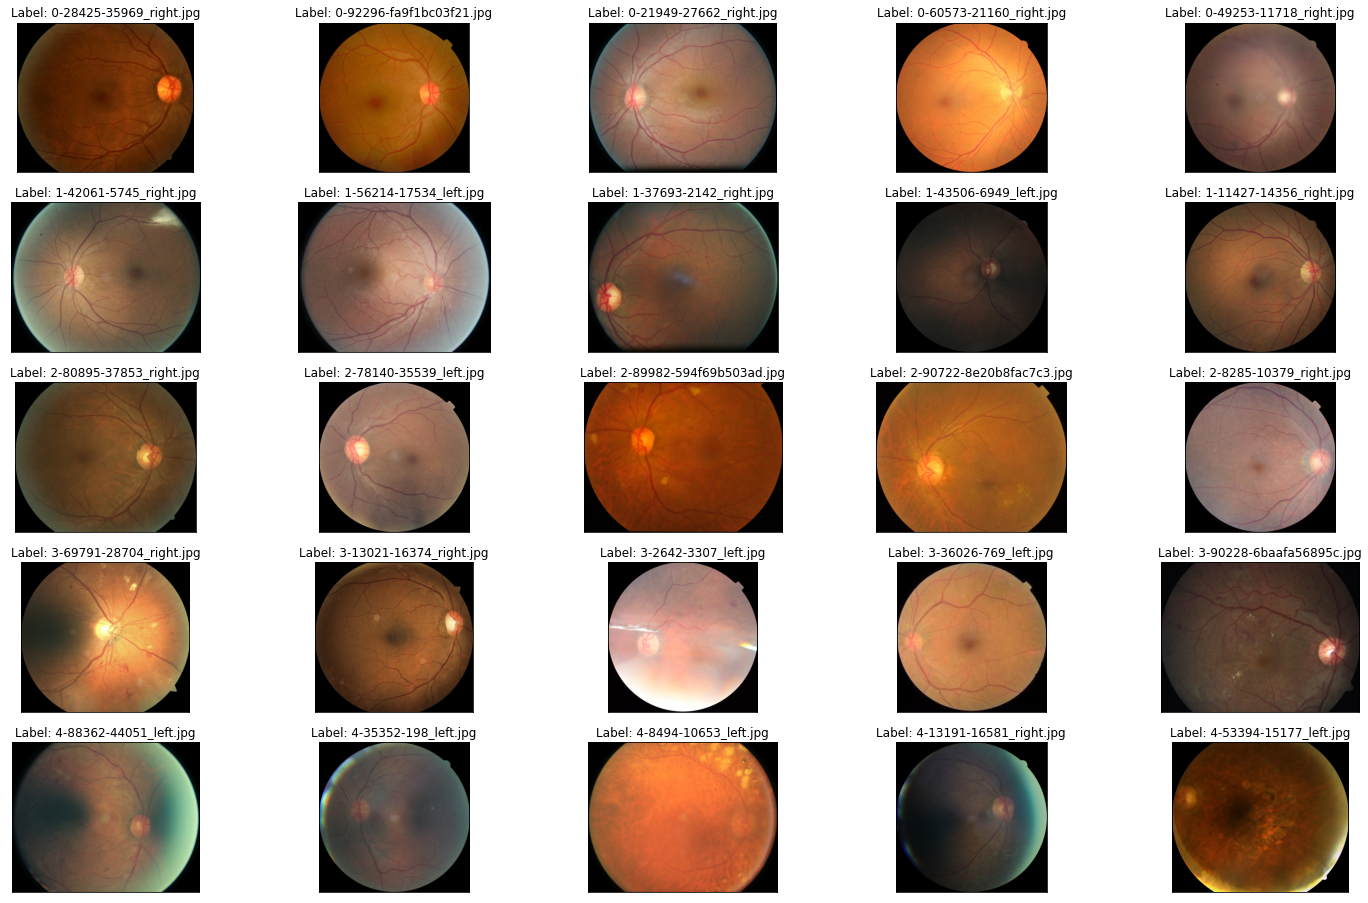

In [36]:
#@title sample images (original)
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['class'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=row['fullpath']
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

### Improve image lightning condition

CPU times: user 2.13 s, sys: 3.11 ms, total: 2.13 s
Wall time: 1.04 s


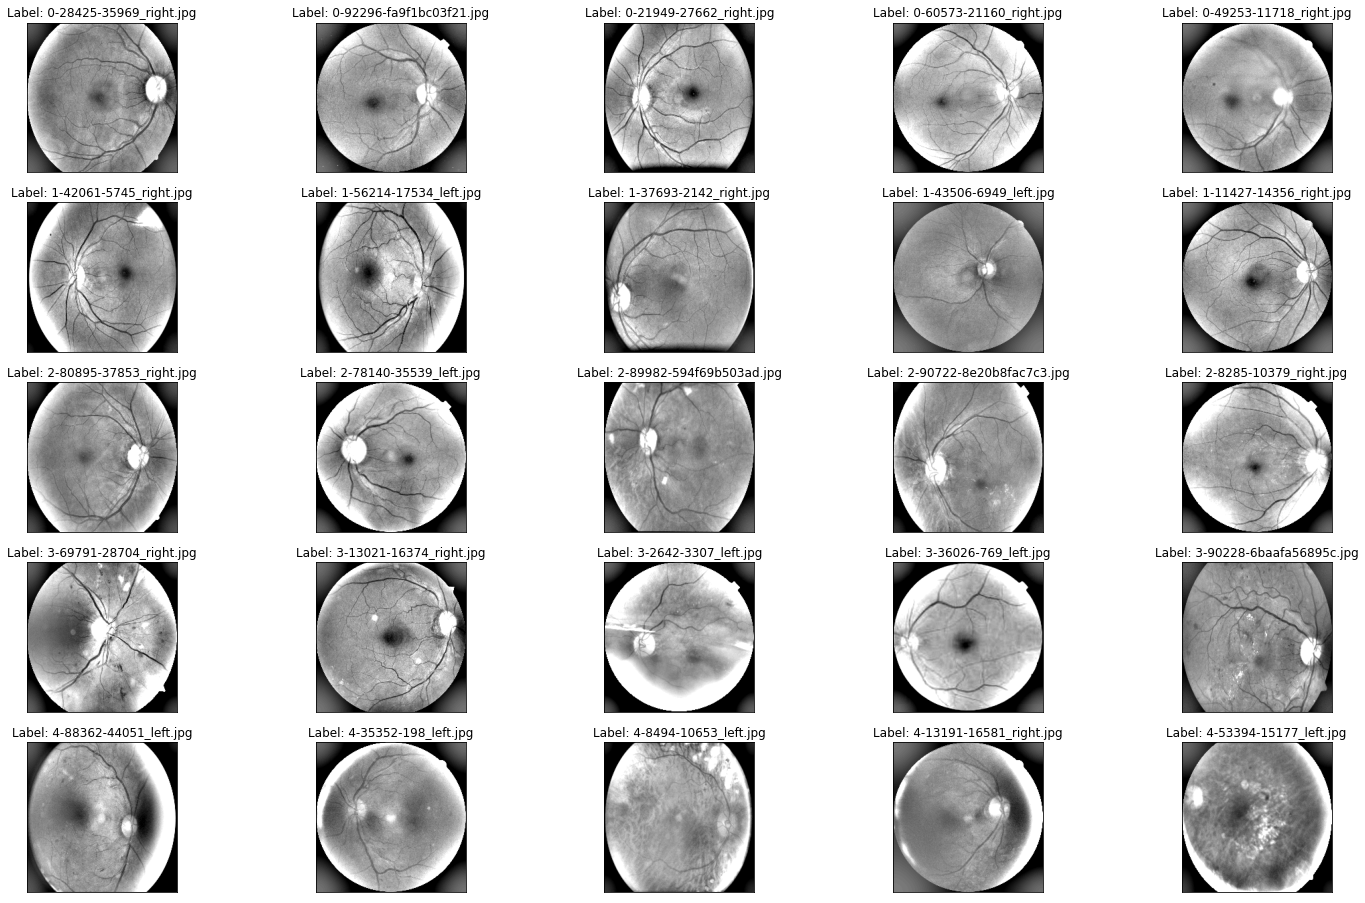

In [37]:
#@title 
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['class'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=row['fullpath']
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

In [38]:
# @title skip
# TF version (gave up)
# %%time
# fig = plt.figure(figsize=(25, 16))
# for class_id in sorted(train_df['class'].unique()):
#     for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
#         ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
#         path=row['fullpath']
#         img = tf.io.read_file(path)
#         img = tf.io.decode_jpeg(img, 3)
#         img = tf.image.rgb_to_grayscale(img)
#         img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        
#         gauss_filter = cv2.GaussianBlur( img.numpy() , (0,0) , IMG_SIZE/10)
#         img = ( 4*tf.squeeze(img,2) ) + (-4 * gauss_filter) + 128
        
#         plt.imshow(img, cmap='gray')
#         ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

In [39]:
#@title skip
#  Compare cv2 and tf version
# OpenCV:   Y ←0.299⋅R+0.587⋅G+0.114⋅B
# TF:       rgb_weights = [0.2989, 0.5870, 0.1140]
# %%time
# plt.figure(figsize=(10, 15))
# for i, (idx, row) in enumerate(train_df.sample(5, random_state=SEED).iterrows()):
#     plt.subplot(5, 2, i * 2 + 1)
#     path=row['fullpath']

#     img_cv = cv2.imread(path)
#     img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
#     img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
#     print(img_cv.dtype)
#     print(np.max(img_cv))
#     img_cv = cv2.resize(img_cv, (IMG_SIZE, IMG_SIZE))
#     # cv_gauss = cv2.GaussianBlur( img_cv , (0,0) , IMG_SIZE/10)
#     # img_cv = cv2.addWeighted ( img_cv,4, cv_gauss ,-4 ,128) # the trick is to add this line
    
#     # plt.imshow(img_cv, cmap='gray')
#     # plt.title('%d-%s' % (idx, row['filename']) )
#     # plt.axis('off')

#     # plt.subplot(5, 2, i * 2 + 2)
#     img_tf = tf.io.read_file(path)
#     img_tf = tf.io.decode_jpeg(img_tf, 3, dct_method='INTEGER_ACCURATE')
#     img_tf = tf.image.rgb_to_grayscale(img_tf)
#     print(img_tf.dtype)
#     print(np.max(img_tf))

#     img_tf = tf.image.resize(img_tf, (IMG_SIZE, IMG_SIZE))

#     # img_tf = ( 4*tf.squeeze(img_tf,2) ) + (-4 * cv_gauss) + 128
    
#     img_tf = tf.squeeze(img_tf,2)

#     plt.imshow(np.abs(img_cv - img_tf), cmap='gray')
#     plt.title('%d-%s' % (idx, row['filename']) )
#     plt.axis('off')

#     break

I want to translate the cv2 code to tensorflow, but sadly the result of are not equivalent, right from the image-reading step :( :( :(

=> Use opencv for preprocessing, not utilize the power of GPU

In [40]:
#@title crop_image_from_gray
def crop_image_from_gray(img,tol=7):
    '''
    Crop the image if the grayscale value < tolerance
    '''
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
    
        return img

In [41]:
#@title load_ben_color
# def crop_image1(img,tol=7):
#     # img is image data
#     # tol  is tolerance
        
#     mask = img>tol
#     return img[np.ix_(mask.any(1),mask.any(0))]



def load_ben_color(path, sigmaX=10):
    '''
    Load the image, crop it based on its grayscale, then resize and enhance the lightning-condition
    '''
    # print("From load_ben_color ",type(path),path)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    # print(type(image))
    return image

CPU times: user 1.83 s, sys: 9.1 ms, total: 1.84 s
Wall time: 1.26 s


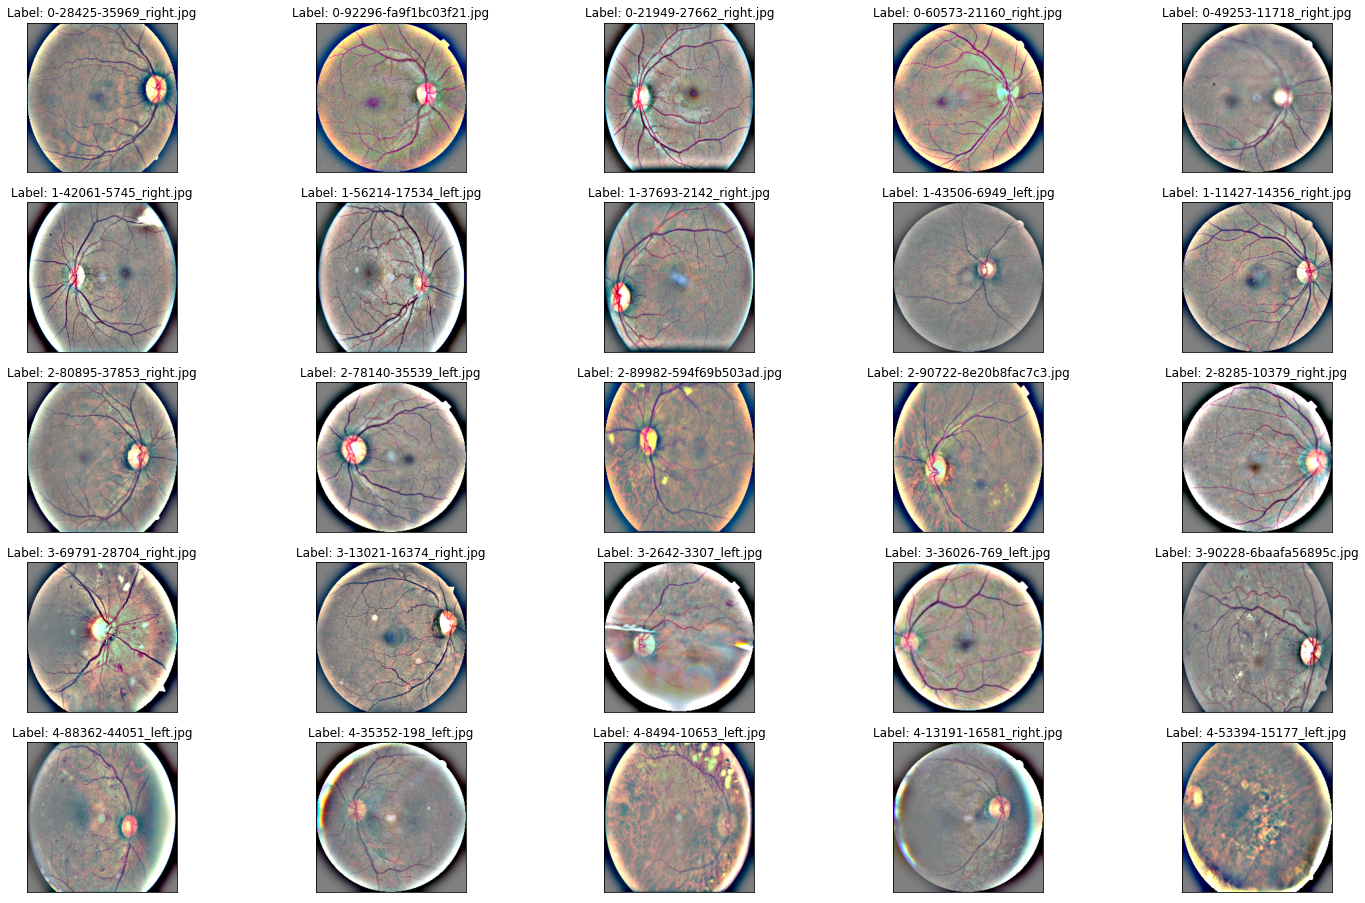

In [42]:
#@title apply load_ben_color on samples
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['class'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=row['fullpath']
        image = load_ben_color(path)

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

In [43]:
#@title circle_crop
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre, also apply lightning condition adjustment
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    # img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

CPU times: user 1.88 s, sys: 35.9 ms, total: 1.92 s
Wall time: 1.71 s


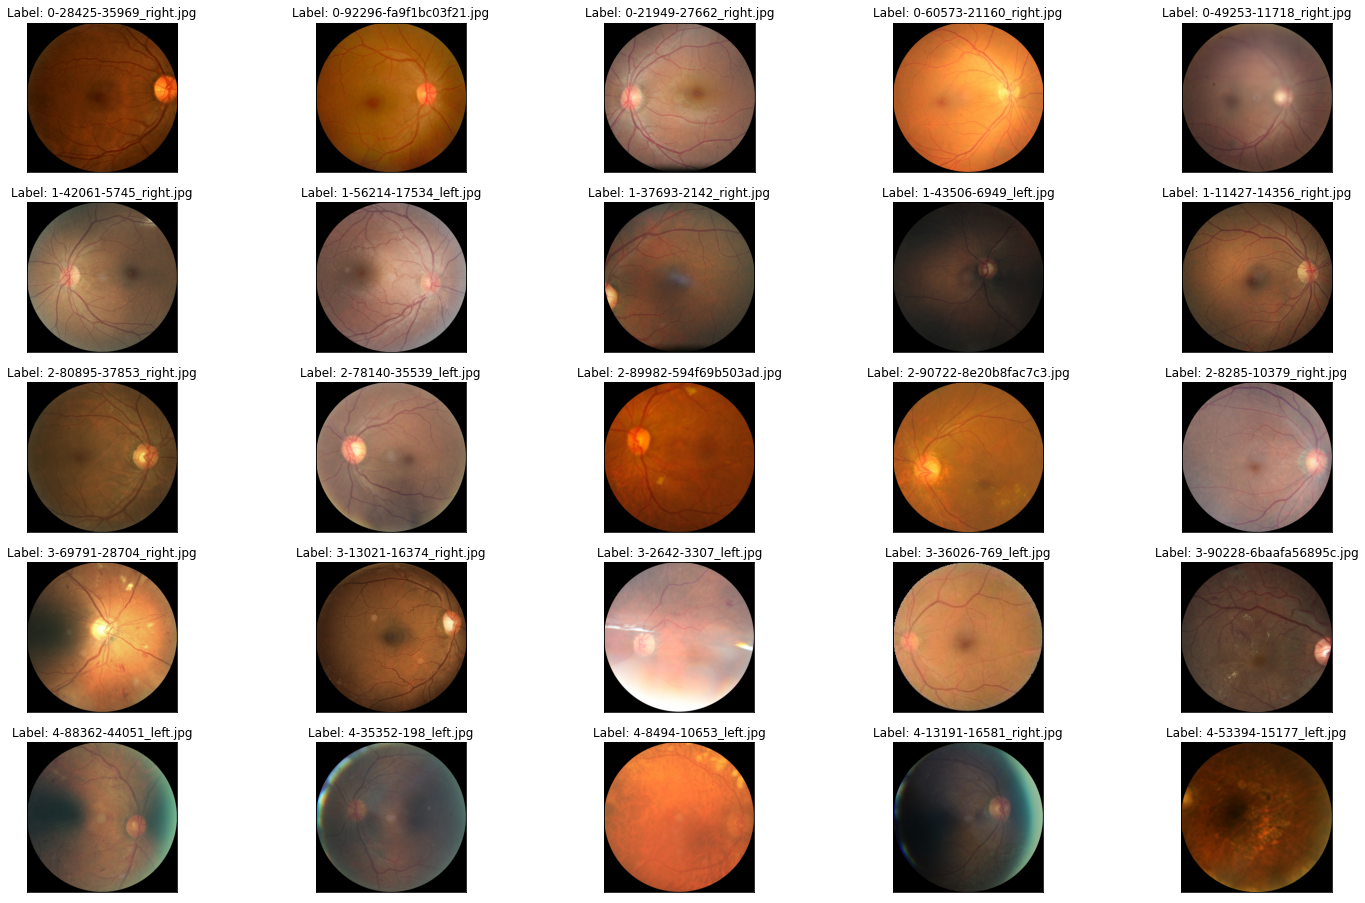

In [44]:
#@title apply circle_crop on samples
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_df['class'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['class'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=row['fullpath']
        image = circle_crop(path)

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['filename']) )

## Preprocess function

### Function

In [45]:
#@title circle_slide square_slice
def circle_slice(img):
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img

def square_slice(img):
    height, width, depth = img.shape    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y)) - (10 if np.amin((height/width,width/height)) < 0.92 else 100)

    square_img = img[(y-r):(y+r),(x-r):(x+r),:]
    return square_img

In [46]:
# @ title load_ben_circle_crop
def load_ben_circle_crop(path, sigmaX=10):   
    """
    Create circular crop around image centre, also apply lightning condition adjustment
    """    
    
    img = cv2.imread(path)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = augment_image(img) ##############
    
    img = square_slice(img) # square_slice circle_slice
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img     

In [74]:
#@title ben_color
def ben_color(img, sigmaX = 10):
    '''
    Improve lightning condition
    '''
    return cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , sigmaX) ,-4 ,128)

In [48]:
#@title augment_image
def augment_image(img, label):
    # img = tfa.image.equalize(img, bins = 256)
    # img = img.numpy()
    if type(img) != np.ndarray :
        img = img.numpy()
    # img = tf.keras.preprocessing.image.random_shift(img, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2,fill_mode='constant', cval=0.0)
    img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
    if type(img) != np.ndarray : 
        img = img.numpy()
    img = tf.keras.preprocessing.image.random_rotation(img, 90, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0)
    img = tf.keras.preprocessing.image.random_shear(img, 10, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0, interpolation_order=1)
    img = ben_color(img)

    if type(img) != np.ndarray :
        img = img.numpy()

    return img, label
def parse_func_aug(img_name, label):
    oimage, olabel = tf.py_function(augment_image, [img_name,label], (tf.float32, tf.uint8))
    oimage.set_shape([IMG_SIZE, IMG_SIZE, 3])
    olabel.set_shape([5])
    return oimage, olabel

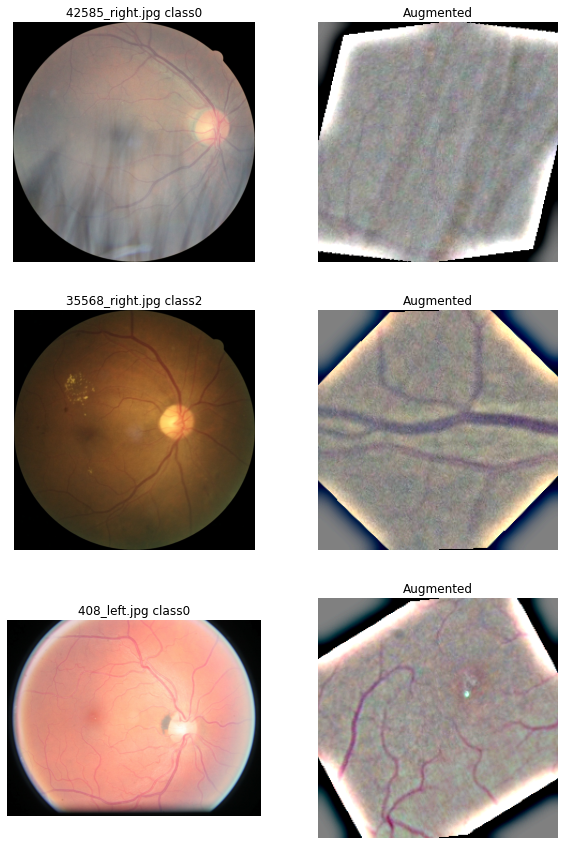

In [49]:
def dummy():

    def quick_plot(img, title):
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    ncols = 2
    tmp = df.sample(3)
    plt.figure(figsize=(10,15))
    for i in range(tmp.shape[0]) :
        img = cv2.imread(tmp.iloc[i,2])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(3,ncols, i*ncols + 1)
        quick_plot(img,tmp.iloc[i,0]+' class'+tmp.iloc[i,1])
        
        plt.subplot(3,ncols, i*ncols + 2)
        pltimg = square_slice(img)
        pltimg,_ = augment_image(pltimg, tmp.iloc[i,1])
        # pltimg = ben_color(pltimg)
        quick_plot(pltimg,'Augmented')
        # break

dummy()

In [50]:
#@title preprocess_train
def preprocess_train(img_name, label) :
    if (type(img_name) != str)  :
        img_name = img_name.numpy().decode("utf-8")
    
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = square_slice(img) # square_slice circle_slice
    # if type(img) != np.ndarray :
    #     img = img.numpy()
    img = cv2.resize(img, (IMG_SIZE+25, IMG_SIZE+25))
    img = img.astype('uint8')

    label = tf.keras.utils.to_categorical(label, num_classes=5)
    label = tf.cast(label,tf.uint8)
    return img, label

def parse_func_train(img_name, label):
    '''
    Wrap the preprocess function (with cv2 inside) with tf.py_function 
    so that it can run inside dataset API pipeline,
    as well as can be placed on GPU and can work with eager tensors.
    
    Need to specify the input tensor, and the output dtype
    '''
    oimage, olabel = tf.py_function(preprocess_train, [img_name,label], (tf.uint8, tf.uint8))
    oimage.set_shape([IMG_SIZE+25, IMG_SIZE+25, 3])
    olabel.set_shape([5])
    return oimage, olabel

In [51]:
#@title preprocess_test
def preprocess_test(img_name, label) :
    
    if type(img_name) != str :
        img_name = img_name.numpy().decode("utf-8")
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = ben_color(img)
    img = img.astype('float32')

    label = tf.keras.utils.to_categorical(label, num_classes=5)
    label = tf.cast(label,tf.uint8)
    return img, label

def parse_func_test(img_name, label):
    '''
    Wrap the preprocess function (with cv2 inside) with tf.py_function 
    so that it can run inside dataset API pipeline,
    as well as can be placed on GPU and can work with eager tensors.
    
    Need to specify the input tensor, and the output dtype
    '''
    oimage, olabel = tf.py_function(preprocess_test, [img_name,label], (tf.float32, tf.uint8))
    oimage.set_shape([IMG_SIZE, IMG_SIZE, 3])
    olabel.set_shape([5])
    return oimage, olabel

(-0.5, 223.5, 223.5, -0.5)

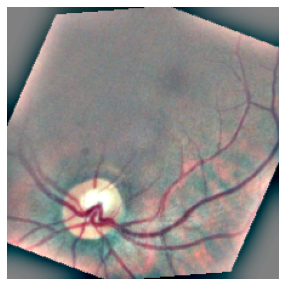

In [52]:
sample = df.sample(1)
img = cv2.imread(sample['fullpath'].iloc[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = crop_image_from_gray(img)
img = square_slice(img)
img = cv2.resize(img, (IMG_SIZE+25, IMG_SIZE+25))
# img = img.astype('float32')
if type(img) != np.ndarray :
    img = img.numpy()
# img = tf.keras.preprocessing.image.random_shift(img, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2,fill_mode='constant', cval=0.0)
img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
if type(img) != np.ndarray : 
    img = img.numpy()
img = tf.keras.preprocessing.image.random_rotation(img, 90, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0)
img = tf.keras.preprocessing.image.random_shear(img, 10, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant', cval=0.0, interpolation_order=1)
img = ben_color(img)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')

In [136]:
#@title preprocess_feature_extract
def preprocess_feature_extract(img_name, label) :
    if type(img_name) != str :
        img_name = img_name.numpy().decode("utf-8")
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = square_slice(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = ben_color(img)
    img = img.astype('float32')
    img = vgg16.preprocess_input(img)

    label = tf.keras.utils.to_categorical(label, num_classes=5)
    label = tf.cast(label,tf.uint8)
    return img, label

def parse_func_extract(img_name, label):
    oimage, olabel = tf.py_function(preprocess_feature_extract, [img_name,label], (tf.float32, tf.uint8))
    oimage.set_shape([IMG_SIZE, IMG_SIZE, 3])
    olabel.set_shape([5])
    return oimage, olabel

### Test preprocessing in tf.data.Dataset

"TypeError: 'NoneType' object cannot be interpreted as an integer" appears when I remove "GREEN extraction"

Swapping resize and equalization show that the **equalization** issues this message

Priting out the shape and type at each step of the `preprocess` function show that after the `tf.cast` step, the number of channels is `None`. Meanwhile, after `tf.expand_dims`, the number of channels is specified (as 1)

Documentation of `tfa.image.equalize` states that: "The rank must be statically known (the shape is not TensorShape(None))." So this function does not accept `None` shape.


=> Adding `tf.reshape` after `tf.cast` to ensure the number of channels

#### On individual file

In [53]:
# test error with preprocess with dataset if any
(x, y) = (0,5)
all_img_path = df['fullpath'][x:y].values
all_label = df['class'][x:y].values

for path, label in tq.tqdm(zip(all_img_path, all_label)) :
    # try :
        preprocess_train(path, label)
        parse_func_train(path, label)
        preprocess_test(path, label)
        parse_func_test(path, label)

        img, label = parse_func_train(path, label)
        augment_image(img, label)
        parse_func_aug(img, label)
    # except:
    #     print("Error: ",path, label)

#### On train mode

In [54]:
all_path = df['fullpath'].values
all_class = df['class'].values
checkds = Dataset.from_tensor_slices((all_path, all_class))
checkds = checkds.map(parse_func_train, num_parallel_calls = AUTOTUNE)
checkds = checkds.shuffle(1000)
checkds = checkds.cache()
checkds = checkds.map(parse_func_aug, num_parallel_calls = AUTOTUNE)
checkds = checkds.batch(4)
checkds = checkds.prefetch(AUTOTUNE)

CPU times: user 53.8 s, sys: 989 ms, total: 54.8 s
Wall time: 14.2 s


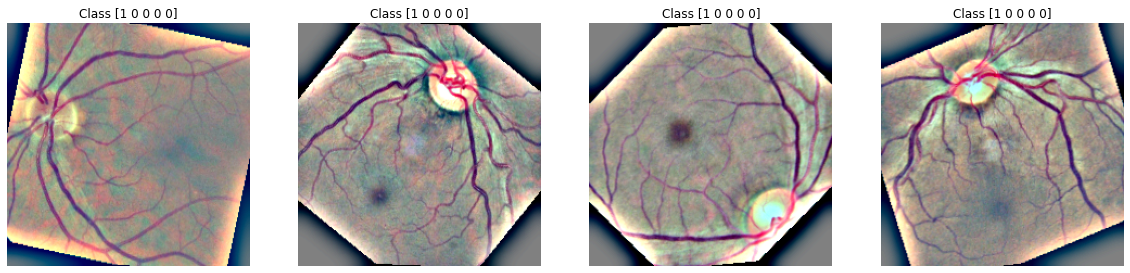

In [55]:
%%time
image_batch, label_batch = next(iter(checkds))

img_ix = 1
ncols = 4
nrows = image_batch.shape[0] // ncols
plt.figure(figsize=(20,10))
    
for img in image_batch :
    plt.subplot(nrows,ncols,img_ix)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title("Class " + str(label_batch[img_ix - 1].numpy()))
    plt.axis("off")
    img_ix +=1

#### On test mode

In [56]:
all_path = df['fullpath'].values
all_class = df['class'].values
checkds = Dataset.from_tensor_slices((all_path, all_class))
checkds = checkds.map(parse_func_test, num_parallel_calls = AUTOTUNE)
checkds = checkds.shuffle(1000)
checkds = checkds.cache()
checkds = checkds.batch(4)
checkds = checkds.prefetch(AUTOTUNE)

CPU times: user 1min 11s, sys: 1.06 s, total: 1min 12s
Wall time: 18.7 s


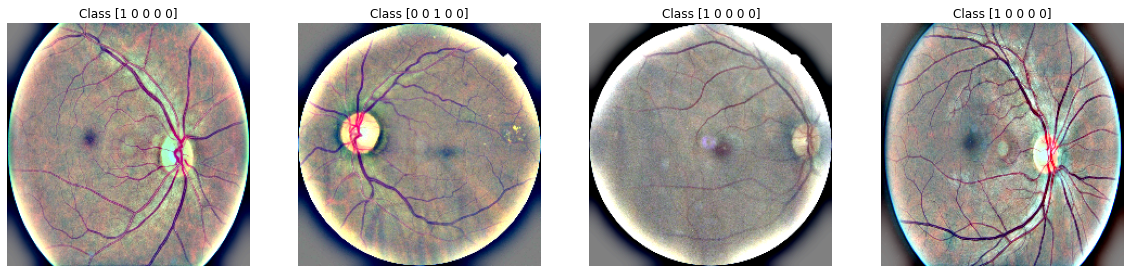

In [57]:
%%time
image_batch, label_batch = next(iter(checkds))

img_ix = 1
ncols = 4
nrows = image_batch.shape[0] // ncols
plt.figure(figsize=(20,10))
    
for img in image_batch :
    plt.subplot(nrows,ncols,img_ix)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title("Class " + str(label_batch[img_ix - 1].numpy()))
    plt.axis("off")
    img_ix +=1

In [58]:
# for img, label in checkds.take(1):
#     print(img.shape)
#     print(label.shape)

#### On feature extract

In [137]:
all_path = df['fullpath'].values
all_class = df['class'].values
checkds = Dataset.from_tensor_slices((all_path, all_class))
checkds = checkds.map(parse_func_extract, num_parallel_calls = AUTOTUNE)
checkds = checkds.shuffle(1000)
checkds = checkds.cache()
checkds = checkds.batch(4)
checkds = checkds.prefetch(AUTOTUNE)

CPU times: user 1min 11s, sys: 1.16 s, total: 1min 13s
Wall time: 18.9 s


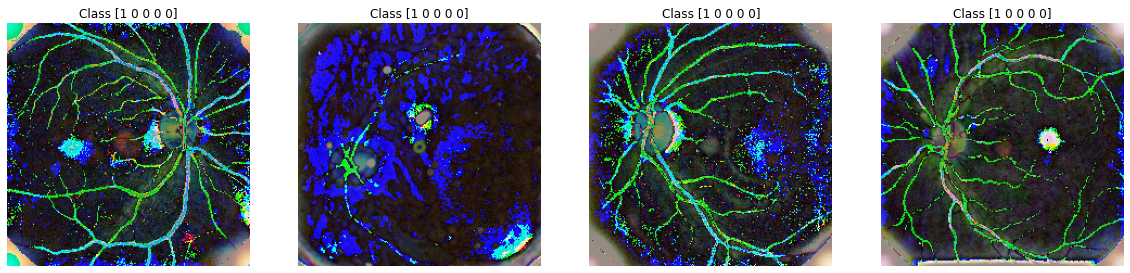

In [138]:
%%time
image_batch, label_batch = next(iter(checkds))

img_ix = 1
ncols = 4
nrows = image_batch.shape[0] // ncols
plt.figure(figsize=(20,10))
    
for img in image_batch :
    plt.subplot(nrows,ncols,img_ix)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title("Class " + str(label_batch[img_ix - 1].numpy()))
    plt.axis("off")
    img_ix +=1

# Make generators

In [65]:
AUTOTUNE = tf.data.AUTOTUNE

In [66]:
def make_train_ds(train_df):
    input = train_df['fullpath']
    output = train_df['class']
    train_ds = Dataset.from_tensor_slices((input, output))
    train_ds = train_ds.map(parse_func_train, num_parallel_calls = AUTOTUNE)
    train_ds = train_ds.shuffle(1000)
    train_ds = train_ds.cache()
    train_ds = train_ds.map(parse_func_aug, num_parallel_calls = AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE)
    train_ds = train_ds.prefetch(AUTOTUNE)
    return train_ds

In [67]:
train_ds = make_train_ds(train_df)
# properly check shape and dtype of input and label generated from Dataset
# image_batch, label_batch = next(iter(train_ds))
# print(tf.TensorSpec.from_tensor(image_batch) , tf.TensorSpec.from_tensor(label_batch))

In [68]:
def make_val_ds(val_df):
    input = val_df['fullpath']
    output = val_df['class']
    val_ds = Dataset.from_tensor_slices((input, output))
    val_ds = val_ds.map(parse_func_test, num_parallel_calls = AUTOTUNE)
    val_ds = val_ds.cache()
    val_ds = val_ds.batch(BATCH_SIZE)
    val_ds = val_ds.prefetch(AUTOTUNE)
    return val_ds

In [69]:
val_ds = make_val_ds(val_df)
# val_image_batch, val_label_batch = next(iter(val_ds))
# print(tf.TensorSpec.from_tensor(val_image_batch) , tf.TensorSpec.from_tensor(val_label_batch))

# Make callbacks

In [70]:
def make_callbacks() :
    cb_earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
    return [cb_earlystop]

# Feature extract

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

## VGG16 feature extraction

In [71]:
from tensorflow.keras.applications import vgg16

In [72]:
base_model = tf.keras.applications.VGG16(
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False
)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# def make_model():
#   inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#   x = vgg16.preprocess_input(inputs)
#   x = base_model(x, training = False)
#   model = tf.keras.Model(inputs, x)
#   return model

# model = make_model()
# model.summary()

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def extract_features(df, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 5))

    all_path = df['fullpath'].values
    all_class = df['class'].values
    checkds = Dataset.from_tensor_slices((all_path, all_class))
    checkds = checkds.map(parse_func_extract, num_parallel_calls = AUTOTUNE) #parse_func_extract already done vgg16.preprocess_input
    checkds = checkds.cache()
    checkds = checkds.batch(BATCH_SIZE)
    checkds = checkds.prefetch(AUTOTUNE)

    i = 0
    for inputs_batch, labels_batch in iter(checkds):
        features_batch = base_model.predict(inputs_batch)
        features[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = features_batch
        labels[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = labels_batch
        i += 1

        if i%100==0:
            print('Batch', i)

        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

In [169]:
np.__version__

'1.19.5'

In [166]:
n_train = 16000
n_val = 4000
%time train_features, train_labels = extract_features(train_df, n_train)
train_features = np.reshape(train_features, (n_train, 7*7*512))

Batch 100
Batch 200


Exception ignored in: <function CapturableResource.__del__ at 0x7f3e239e5710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 269, in __del__
    with self._destruction_context():
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 817, in _mode
    self.context_switches.push(False, eager_mode, None)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/context.py", line 232, in push
    self.stack.append(
AttributeError: '_ContextSwitchStack' object has no attribute 'stack'
Exception ignored in: <function CapturableResource.__del__ at 0x7f3e239e5710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 269, in __del__
    with self._destruction_context():
  File "/usr/lib

Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
CPU times: user 21min 1s, sys: 41.7 s, total: 21min 43s
Wall time: 5min 57s


In [167]:
%time validation_features, validation_labels = extract_features(val_df, n_val)
validation_features = np.reshape(validation_features, (n_val, 7*7*512))

Batch 100
Batch 200
CPU times: user 5min 9s, sys: 5.81 s, total: 5min 15s
Wall time: 1min 25s


In [168]:
train_features.shape, train_labels.shape, validation_features.shape, validation_labels.shape

((16000, 25088), (16000, 5), (4000, 25088), (4000, 5))

## PCA

### Find right number of components

In [93]:
from sklearn.decomposition import PCA
pca_full = PCA()
%time pca_full.fit(train_features)

# print(pca.components_)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [94]:
print(pca_full.explained_variance_ratio_)
print(pca_full.explained_variance_ratio_.sum())

[1.21290815e-01 4.66915632e-02 3.60073194e-02 ... 5.46338796e-07
 2.39217551e-32 9.69203807e-34]
0.9999999999999999


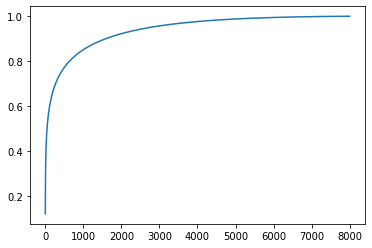

In [98]:
import seaborn as sns
tmp = pca_full.explained_variance_ratio_.cumsum()
plt.plot(tmp)

In [99]:
tmp[1000], tmp[2000]

(0.8512936381512402, 0.9225179587970617)

### PCA transform

In [100]:
%%time
pca = PCA(n_components=2000)
pca.fit(train_features)

PCA(copy=True, iterated_power='auto', n_components=2000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [101]:
train_features_pca = pca.transform(train_features)
validation_features_pca = pca.transform(validation_features)

In [145]:
x_train_pca = train_features_pca
y_train = np.argmax(train_labels, axis = 1)

x_val_pca = validation_features_pca
y_val = np.argmax(validation_labels, axis = 1)

## Light GBM only

#### With class weight

In [149]:
clf = lgb.LGBMClassifier(class_weight = class_weight)
clf.fit(x_train_pca, y_train)

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.2750956941362208, 1: 2.810010649627263,
                             2: 1.3054990104608426, 3: 8.100964912280702,
                             4: 8.361339972838389},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [150]:
y_train_pred = clf.predict(x_train_pca)

In [151]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5800
           1       1.00      1.00      1.00       570
           2       1.00      1.00      1.00      1239
           3       1.00      1.00      1.00       196
           4       1.00      1.00      1.00       195

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [152]:
y_val_pred = clf.predict(x_val_pca)

In [153]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1483
           1       1.00      0.01      0.01       148
           2       0.32      0.17      0.22       281
           3       0.00      0.00      0.00        45
           4       0.40      0.05      0.08        43

    accuracy                           0.74      2000
   macro avg       0.50      0.24      0.24      2000
weighted avg       0.70      0.74      0.67      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Resampling

### Oversampling

In [155]:
oversampler = SMOTE(sampling_strategy='minority', n_jobs=-1, random_state=SEED)
clf = lgb.LGBMClassifier()

pipeline = imbPipeline([
    ('sampler', oversampler),
    ('transformer', StandardScaler()),
    ('classifier', clf)
])

pipeline.fit(x_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('sampler',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=-1,
                       out_step='deprecated', random_state=25, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('transformer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.0,
        

In [156]:
y_train_pred = pipeline.predict(x_train_pca)

In [157]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5800
           1       1.00      1.00      1.00       570
           2       1.00      0.99      1.00      1239
           3       1.00      1.00      1.00       196
           4       1.00      1.00      1.00       195

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



Text(0.5, 24.0, 'Predicted label')

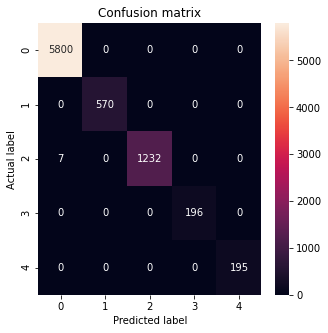

In [165]:
labels = val_df['class'].astype('int8')

cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [158]:
y_val_pred = pipeline.predict(x_val_pca)

In [161]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1483
           1       0.00      0.00      0.00       148
           2       0.50      0.01      0.02       281
           3       0.00      0.00      0.00        45
           4       0.23      0.28      0.25        43

    accuracy                           0.74      2000
   macro avg       0.30      0.26      0.22      2000
weighted avg       0.63      0.74      0.64      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 24.0, 'Predicted label')

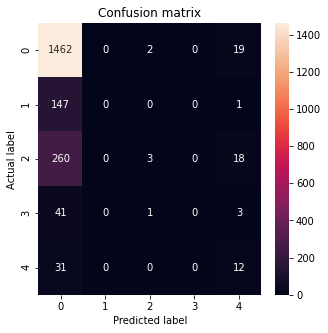

In [164]:
labels = val_df['class'].astype('int8')

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Undersampling

In [ ]:
oversampler = SMOTE(sampling_strategy='minority', n_jobs=-1, random_state=SEED)
clf = lgb.LGBMClassifier()

pipeline = imbPipeline([
    ('sampler', oversampler),
    ('transformer', StandardScaler()),
    ('classifier', clf)
])

pipeline.fit(x_train_pca, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('sampler',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=-1,
                       out_step='deprecated', random_state=25, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('transformer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.0,
        

In [ ]:
y_train_pred = pipeline.predict(x_train_pca)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5800
           1       1.00      1.00      1.00       570
           2       1.00      0.99      1.00      1239
           3       1.00      1.00      1.00       196
           4       1.00      1.00      1.00       195

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [ ]:
y_val_pred = pipeline.predict(x_val_pca)

In [ ]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1483
           1       0.00      0.00      0.00       148
           2       0.50      0.01      0.02       281
           3       0.00      0.00      0.00        45
           4       0.23      0.28      0.25        43

    accuracy                           0.74      2000
   macro avg       0.30      0.26      0.22      2000
weighted avg       0.63      0.74      0.64      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Make baseline models 

## Helpers

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_acc_loss(history, baseline_hist = None, auc = False):
    train_acc = history.history['accuracy']
    val_acc = None
    val_loss = None
    if 'val_accuracy' in history.history.keys(): 
        val_acc = history.history['val_accuracy'] 
    train_loss = history.history['loss']
    if 'val_loss' in history.history.keys():
        val_loss = history.history['val_loss'] 
    if 'val_accuracy' in history.history.keys(): 
        val_acc = history.history['val_accuracy'] 
    if auc:
        train_auc = hi

    epochs = range(1,len(train_acc)+1)

    if baseline_hist is not None:
        base_train_acc = baseline_hist.history['accuracy'][:len(train_acc)]
        if 'val_accuracy' in history.history.keys():
            base_val_acc = baseline_hist.history['val_accuracy'][:len(train_acc)] 
        base_train_loss = baseline_hist.history['loss'][:len(train_acc)]
        if 'val_loss' in history.history.keys():
            base_val_loss = baseline_hist.history['val_loss'][:len(train_acc)] 

    plt.figure(figsize = (20,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, 'b', label = 'Train accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
    if baseline_hist is not None:
        plt.plot(epochs, base_train_acc, 'b--', alpha = 0.3, label = 'Base model train accuracy')
        if base_val_acc:
            plt.plot(epochs, base_val_acc, 'r--', alpha = 0.3, label = 'Base model validation accuracy')
    plt.legend()
    plt.title('Training and validataion accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, 'b', label = 'Train loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    if baseline_hist is not None:
        plt.plot(epochs, base_train_loss, 'b--', alpha = 0.3, label = 'Base model train loss')
        if base_val_loss:
            plt.plot(epochs, base_val_loss, 'r--', alpha = 0.3, label = 'Base model validation loss')
    plt.legend()
    plt.title('Train and validataion loss')